In [1]:
import datetime
import numpy as np
import math
import statistics 
import pandas as pd
from pandas_datareader import data 

from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split


import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.dates import YearLocator, MonthLocator
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Import Stocks from yahoo Finance and process data

In [2]:
ticker = "TSLA"
start_date = datetime.date(2003, 7, 1)
#end_date = datetime.date
end_date = datetime.date.today()
Stocks = data.DataReader(ticker, 'yahoo', start_date, end_date)

Stocks.to_csv('data/TSLA_data.csv')

In [3]:
Stocks.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2010-06-29,25.00,17.540001,19.000000,23.889999,18766300,23.889999
2010-06-30,30.42,23.299999,25.790001,23.830000,17187100,23.830000
2010-07-01,25.92,20.270000,25.000000,21.959999,8218800,21.959999
2010-07-02,23.10,18.709999,23.000000,19.200001,5139800,19.200001
2010-07-06,20.00,15.830000,20.000000,16.110001,6866900,16.110001


In [4]:
Stocks.shape

(2079, 6)

In [5]:
Stocks.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2079 entries, 2010-06-29 to 2018-09-28
Data columns (total 6 columns):
High         2079 non-null float64
Low          2079 non-null float64
Open         2079 non-null float64
Close        2079 non-null float64
Volume       2079 non-null int64
Adj Close    2079 non-null float64
dtypes: float64(5), int64(1)
memory usage: 113.7 KB


In [6]:
Stocks.describe()

,High,Low,Open,Close,Volume,Adj Close
count,2079.000000,2079.000000,2079.000000,2079.000000,2.079000e+03,2079.000000
mean,170.856027,164.940111,167.970014,167.971357,4.874358e+06,167.971357
std,115.296345,111.808503,113.609635,113.604383,4.458218e+06,113.604383
min,16.629999,14.980000,16.139999,15.800000,1.185000e+05,15.800000
25%,32.980001,31.625000,32.334999,32.359999,1.494200e+06,32.359999
50%,203.500000,196.500000,200.059998,200.100006,3.977500e+06,200.100006
75%,254.825005,248.115005,251.395004,251.415001,6.493900e+06,251.415001
max,389.609985,379.350006,386.690002,385.000000,3.716390e+07,385.000000


In [7]:
Stocks.reset_index(inplace=True,drop=False)
Stocks.drop(['Open','High','Low','Adj Close'],axis=1,inplace=True)
Stocks['Date'] = Stocks['Date'].apply(datetime.datetime.toordinal)
Stocks = list(Stocks.itertuples(index=False, name=None))

In [8]:
dates = np.array([q[0] for q in Stocks], dtype=int)
end_val = np.array([q[1] for q in Stocks])
volume = np.array([q[2] for q in Stocks])[1:]

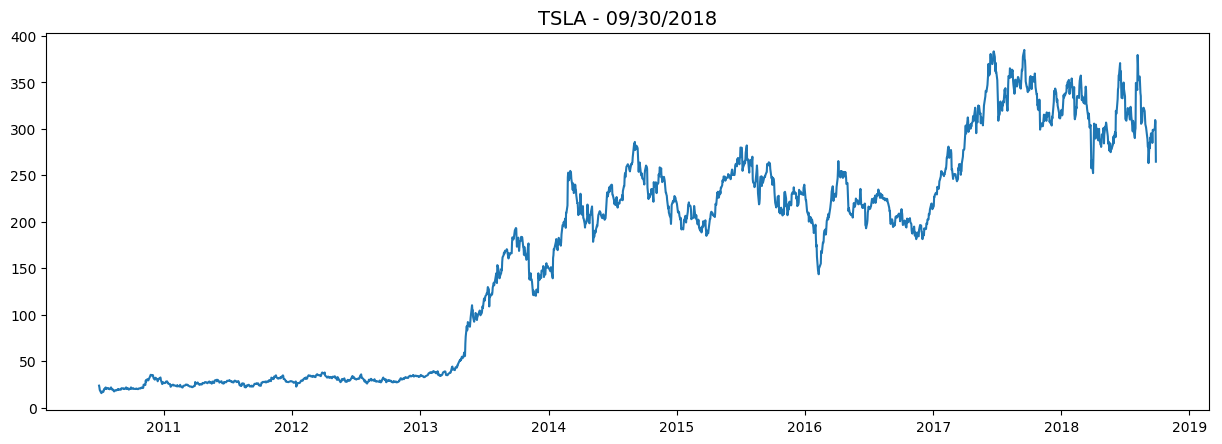

In [9]:
diff = np.diff(end_val)
dates = dates[1:]
end_val = end_val[1:]

X = np.column_stack([diff, volume])
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker + " - " + end_date.strftime("%m/%d/%Y"), fontsize = 14)
plt.gca().xaxis.set_major_locator(YearLocator())
plt.plot_date(dates,end_val,"-")
plt.show()

## Deploy HMMLearn Model and Visualization

In [10]:
model = GaussianHMM(n_components=4, covariance_type="diag", n_iter=1000)
model.fit(X)

GaussianHMM(algorithm='viterbi', covariance_type='diag', covars_prior=0.01,
      covars_weight=1, init_params='stmc', means_prior=0, means_weight=0,
      min_covar=0.001, n_components=4, n_iter=1000, params='stmc',
      random_state=None, startprob_prior=1.0, tol=0.01, transmat_prior=1.0,
      verbose=False)

In [11]:
hidden_states = model.predict(X)

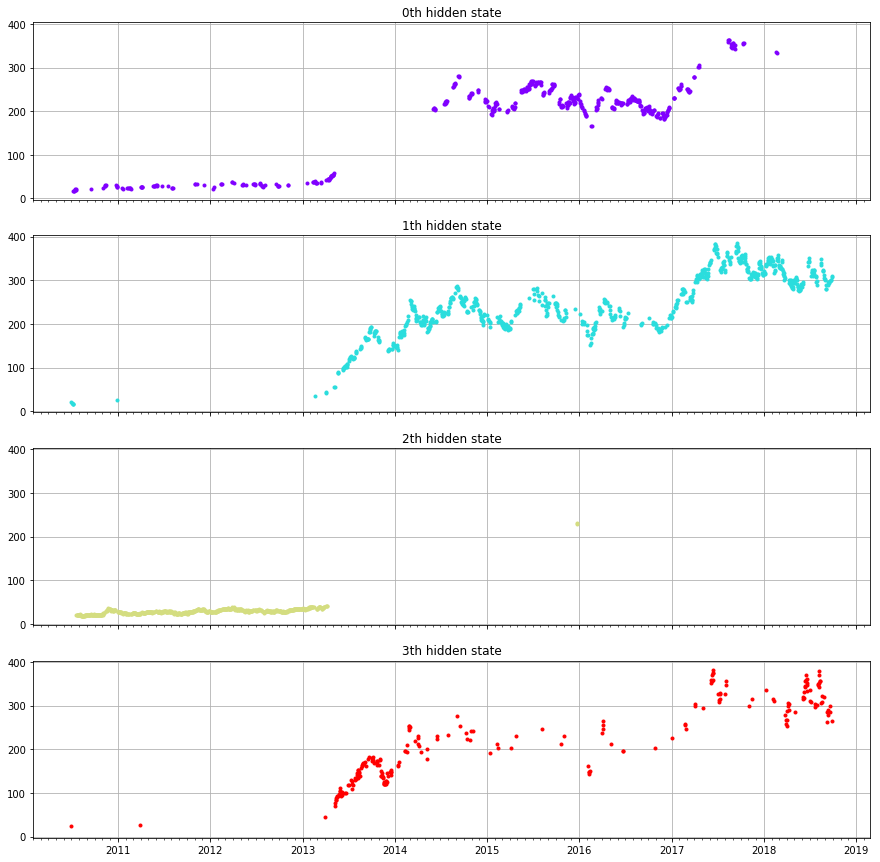

In [13]:
# From HMMLearn Documentation.....

fig, axs = plt.subplots(model.n_components, sharex=True, sharey=True, figsize=(15,15))
colours = cm.rainbow(np.linspace(0, 1, model.n_components))

for i, (ax, colour) in enumerate(zip(axs, colours)):
    # Use fancy indexing to plot data in each state.
    mask = hidden_states == i
    ax.plot_date(dates[mask], end_val[mask], ".", c=colour)
    ax.set_title("{0}th hidden state".format(i))

    # Format the ticks.
    ax.xaxis.set_major_locator(YearLocator())
    ax.xaxis.set_minor_locator(MonthLocator())

    ax.grid(True)
plt.show()

In [20]:
expected_returns_and_volumes = np.dot(model.transmat_, model.means_)
returns_and_volume_columnwise = list(zip(*expected_returns_and_volumes))
expected_returns = returns_and_volume_columnwise[0]
expected_volumes = returns_and_volume_columnwise[1]
params = pd.concat([pd.Series(expected_returns), pd.Series(expected_volumes)], axis=1)
params.columns= ['Returns', 'Volume']
print (params)

    Returns        Volume
0  0.180281  3.576188e+06
1  0.120928  6.559660e+06
2  0.040982  1.173471e+06
3  0.153394  1.152522e+07


In [16]:
lastN = 7
start_date = datetime.date.today() - datetime.timedelta(days=lastN*2) #even beyond N days
end_date = datetime.date.today() 

dates = np.array([q[0] for q in Stocks], dtype=int)

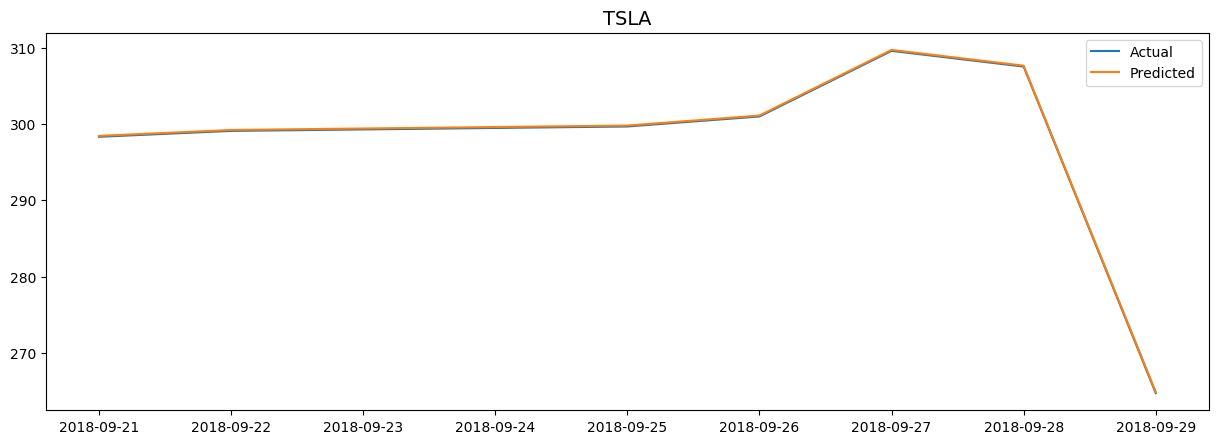

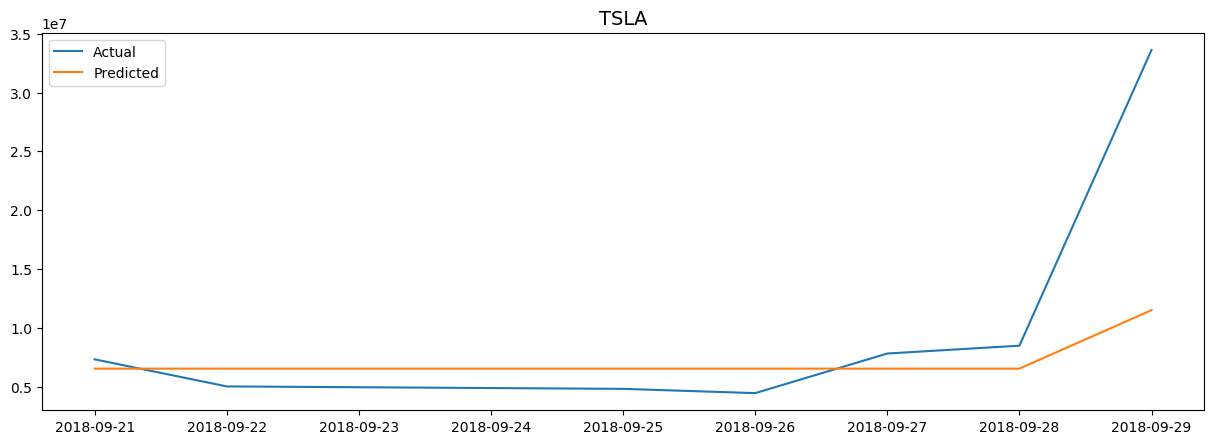

In [21]:
predicted_prices = []
predicted_dates = []
predicted_volumes = []
actual_volumes = []

for idx in range(lastN):
    state = hidden_states[-lastN+idx]
    current_price = Stocks[-lastN+idx][1]
    volume = Stocks[-lastN+idx][2]
    actual_volumes.append(volume)
    current_date = datetime.date.fromordinal(dates[-lastN+idx])
    predicted_date = current_date + datetime.timedelta(days=1)
    predicted_dates.append(predicted_date)
    predicted_prices.append(current_price + expected_returns[state])
    predicted_volumes.append(np.round(expected_volumes[state]))    

#Returns
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,end_val[-lastN:])
plt.plot(predicted_dates,predicted_prices)
plt.legend(['Actual','Predicted'])
plt.show()

#Volumes
plt.figure(figsize=(15, 5), dpi=100) 
plt.title(ticker, fontsize = 14)
plt.plot(predicted_dates,actual_volumes)
plt.plot(predicted_dates,predicted_volumes)
plt.legend(['Actual','Predicted'])
plt.show()

In [23]:
print('Actual:',end_val[-lastN:], '\n','Prediction:', predicted_prices )

Actual: [ 298.32998657  299.1000061   299.67999268  300.98999023  309.57998657
  307.51998901  264.76998901] 
 Prediction: [298.45091443092377, 299.22093396217377, 299.8009205344394, 301.11091809303315, 309.70091443092377, 307.64091687233002, 264.92338301787771]
